In [3]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import math
import scipy

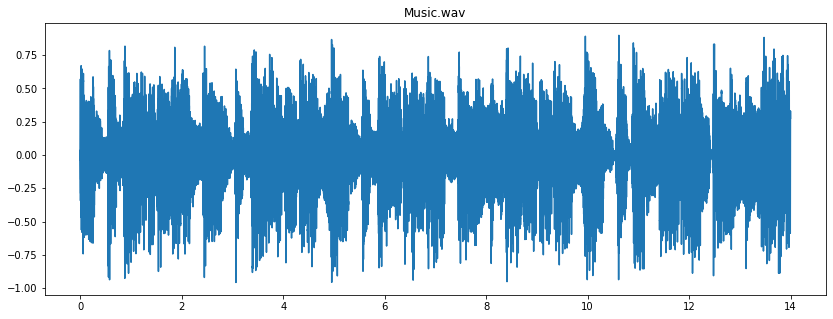

In [4]:
music, fs = librosa.load("music.wav", sr = 44100)
t = np.linspace(0,14,len(music))

plt.figure(figsize = (14, 5))
plt.title('Music.wav')
plt.plot(t, music)

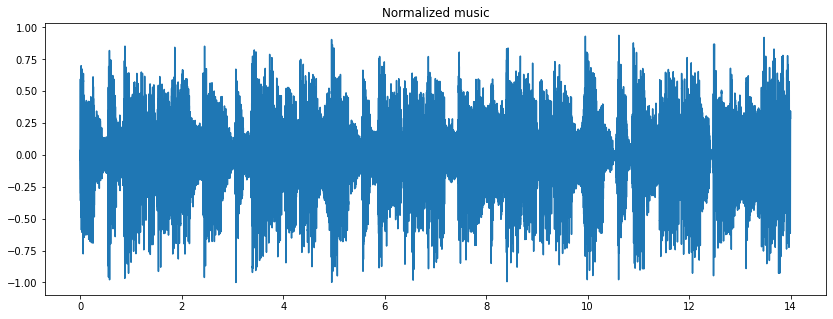

In [5]:
#normalization
max_abs = max(abs(music))
music = music/max_abs

plt.figure(figsize = (14, 5))
plt.title('Normalized music')
plt.plot(t, music)

512


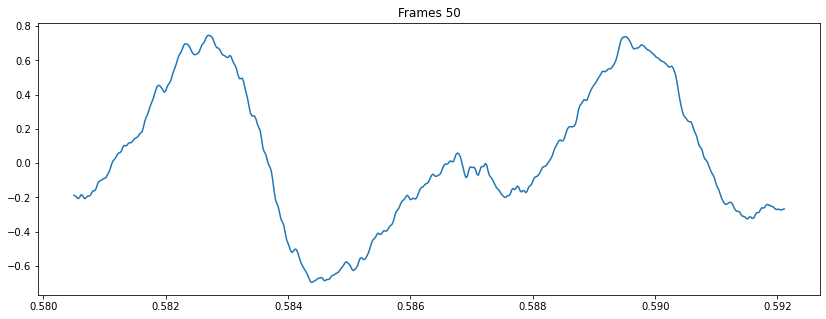

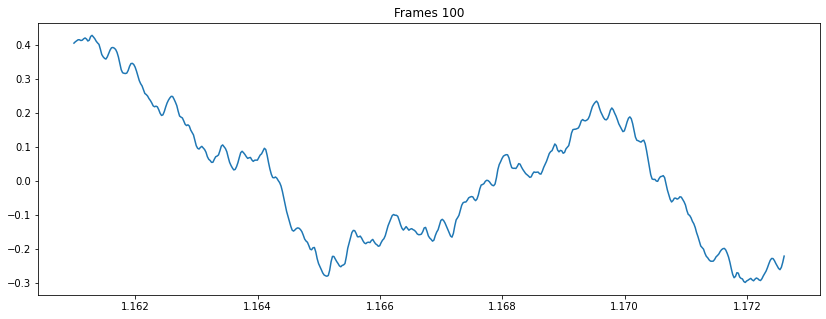

In [6]:
#splitting in frames of 512 samples
N=512
nrframes = len(music)//N

frames = []
for i in range(nrframes):
    frames.append(music[N*i:(i+1)*N])

print(len(frames[50]))
t50 = np.linspace(50*N/fs,51*N/fs,len(frames[50]))
plt.figure(figsize = (14, 5))
plt.title('Frames 50')
plt.plot(t50,frames[50])
plt.show()

t100 = np.linspace(100*N/fs,101*N/fs,len(frames[100]))
plt.figure(figsize = (14, 5))
plt.title('Frames 100')
plt.plot(t100,frames[100])    

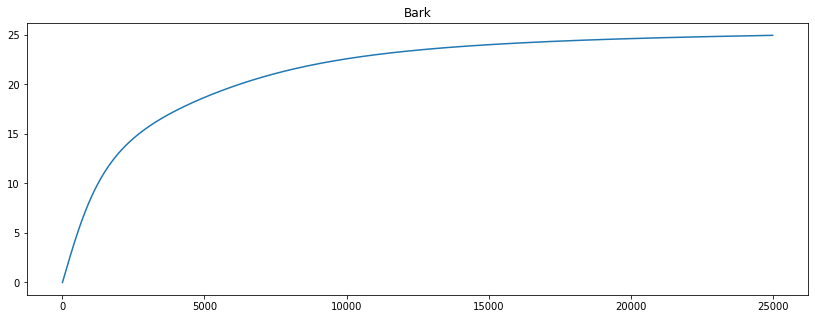

In [7]:
#bark
def bark_creation(f):
    b = 13*np.arctan(0.00076*f) + 3.5*np.arctan(pow((f/7100),2))
    return b

f = np.linspace(0, 2.5*pow(10,4), 2*pow(10,4))

plt.figure(figsize = (14, 5))
plt.title('Bark')
plt.plot(f,bark_creation(f))

In [8]:
freqs = np.linspace(fs/N,fs/2,N//2)
bark = bark_creation(freqs)

window = np.hanning(N)

In [9]:
def p_k (music,window):
    pn = 90.302
    pk = pn + 10*np.log10(pow(abs(np.fft.fft(window*music,N)),2))
    return pk[:N//2]

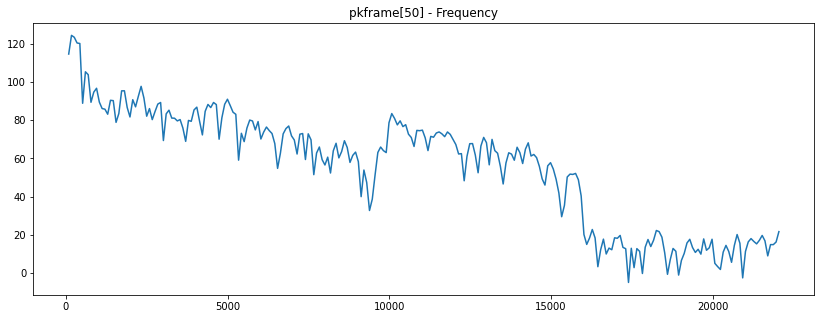

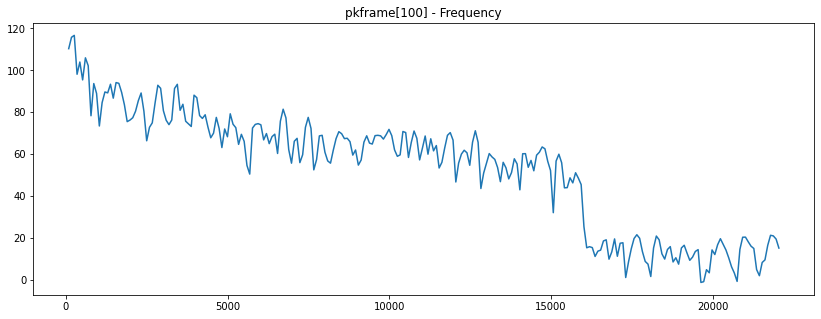

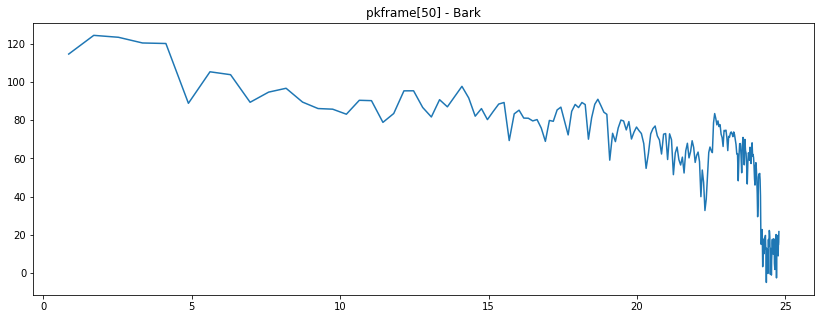

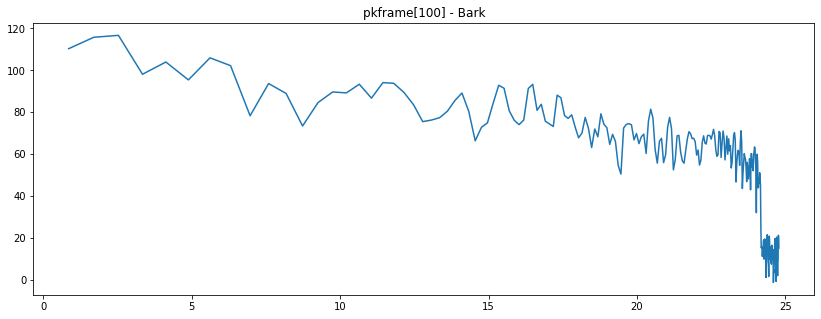

In [10]:
pkframe = []
for i in range(nrframes):
    pkframe.append(p_k(frames[i],window))
    
plt.figure(figsize = (14, 5))
plt.title('pkframe[50] - Frequency')
plt.plot(freqs,pkframe[50])
plt.show()

plt.figure(figsize = (14, 5))
plt.title('pkframe[100] - Frequency')
plt.plot(freqs,pkframe[100])
plt.show()

plt.figure(figsize = (14, 5))
plt.title('pkframe[50] - Bark')
plt.plot(bark,pkframe[50])
plt.show()

plt.figure(figsize = (14, 5))
plt.title('pkframe[100] - Bark')
plt.plot(bark,pkframe[100])
plt.show()

In [11]:
def dk_creation(k):
    if (2<k and k<63):
        return [2,2]
    elif (63<=k and k<127):
        return [2,3]
    elif (127<=k and k<=250):
        return [2,6]
    return []

def st_creation(p_k):
    st_creation = np.zeros(N//2)
    for i in range(3,251):
        if (p_k[i]>p_k[i+1] and p_k[i]>p_k[i-1]):
            b = 1 
            dk=dk_creation(i)
            for j in range(len(dk)):
                t1 = i+dk[j]
                t2 = i-dk[j]
                if (t1>255 or t2 < 0 ): 
                    b=0
                    
                elif (p_k[i]<=p_k[i+dk[j]]+7 or p_k[i]<=p_k[i-dk[j]]+7):
                    b = 0
            st_creation[i]=(b)   
    return st_creation
            
            
def tone_maskers(p_k):
    st = st_creation(p_k)
    p_tm = []
    for i in range(len(st)):
        if (st[i]==1):
            p = 10*np.log10(10**(0.1*p_k[i-1])+10**(0.1*p_k[i])+10**(0.1*p_k[i+1]))
            p_tm.append(p)
        else: p_tm.append(0)
                                                   
    return p_tm

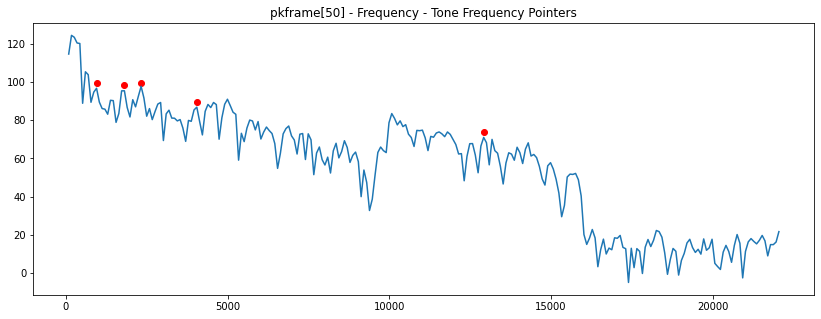

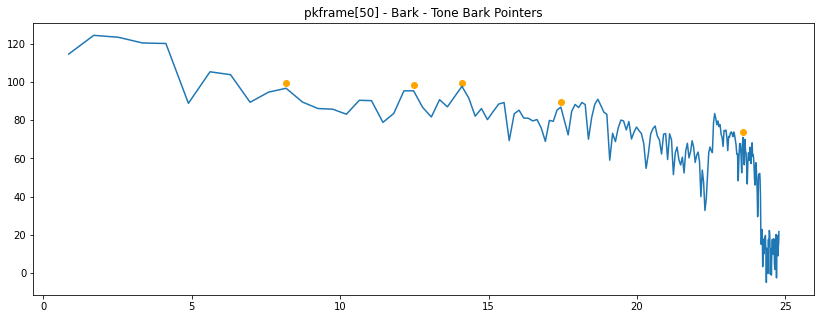

In [12]:
frame_p_tm = []
for i in range(nrframes):
    frame_p_tm.append(tone_maskers(pkframe[i]))

plt.figure(figsize = (14, 5))
plt.title('pkframe[50] - Frequency - Tone Frequency Pointers')
plt.plot(freqs,pkframe[50])

y1= []
for i in frame_p_tm[50]:
        if i == 0:
            i = None
        y1.append(i)
    
plt.scatter(freqs,y1,color="r")
plt.show()

plt.figure(figsize = (14, 5))
plt.title('pkframe[50] - Bark - Tone Bark Pointers')
plt.plot(bark,pkframe[50])
plt.scatter(bark,y1,color="orange")

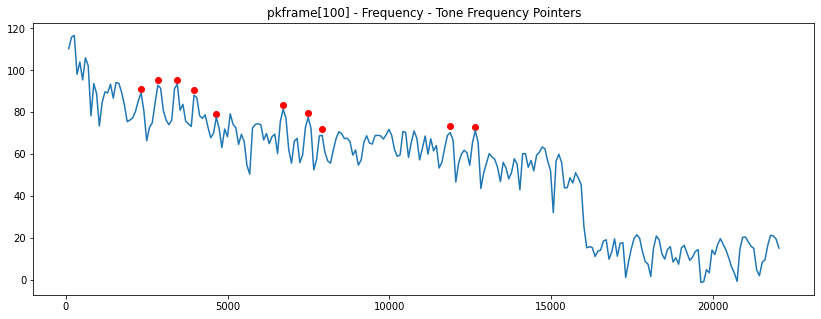

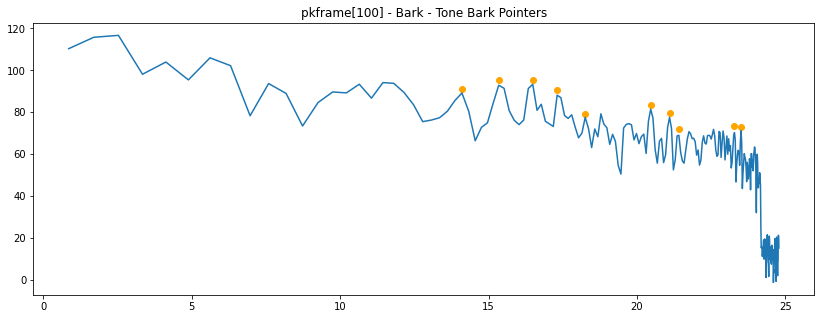

In [13]:
plt.figure(figsize = (14, 5))
plt.title('pkframe[100] - Frequency - Tone Frequency Pointers')
plt.plot(freqs,pkframe[100])

y2= []
for i in frame_p_tm[100]:
        if i == 0:
            i = None
        y2.append(i)
        
plt.scatter(freqs,y2,color="r") 
plt.show()

plt.figure(figsize = (14, 5))
plt.title('pkframe[100] - Bark - Tone Bark Pointers')
plt.plot(bark,pkframe[100])
plt.scatter(bark,y2,color="orange")


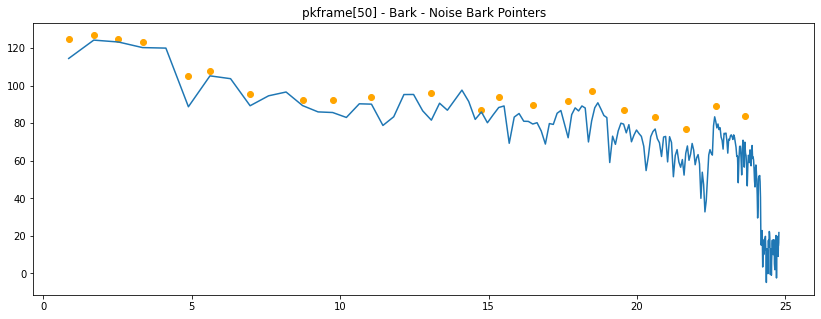

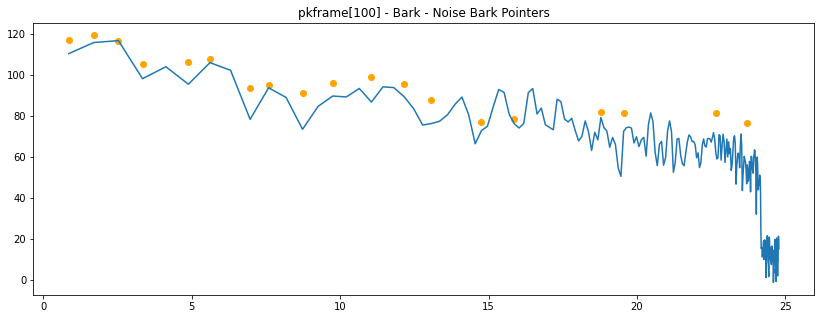

In [14]:
noise_maskers = np.load("P_NM.npy")
noise_maskers = np.transpose(noise_maskers)

y3= []
for i in noise_maskers[50]:
        
        if i == 0:
            i = None
        
        y3.append(i)

plt.figure(figsize = (14, 5))
plt.title('pkframe[50] - Bark - Noise Bark Pointers')
plt.scatter(bark,y3,color="orange")
plt.plot(bark,pkframe[50])
plt.show()

y4= []
for i in noise_maskers[100]:
        
        if i == 0:
            i = None
        
        y4.append(i)
        
plt.figure(figsize = (14, 5))
plt.title('pkframe[100] - Bark - Noise Bark Pointers')
plt.scatter(bark,y4,color="orange")
plt.plot(bark,pkframe[100])

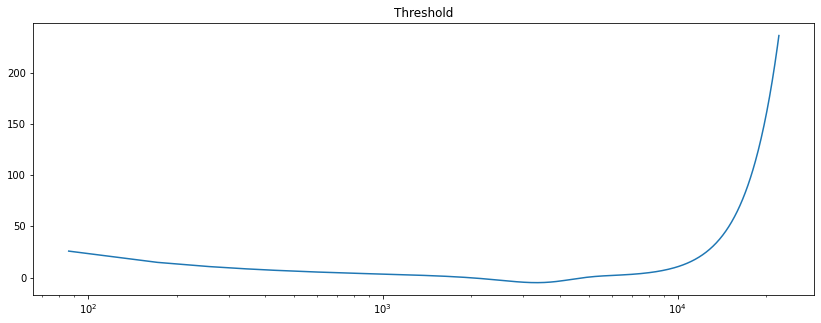

In [15]:
tq = 3.64*((freqs/1000)**(-0.8)) - 6.5*np.exp(-0.6*((freqs/1000-3.3)**2)) + (10**(-3))*((freqs/1000)**4)

plt.figure(figsize = (14, 5))
plt.title('Threshold')
plt.xscale('log')
plt.plot(freqs,tq)

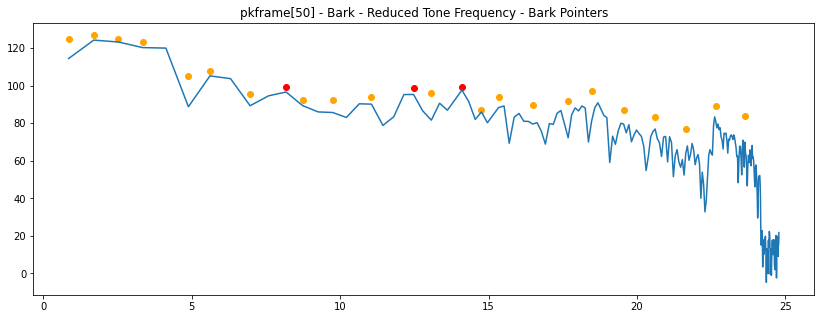

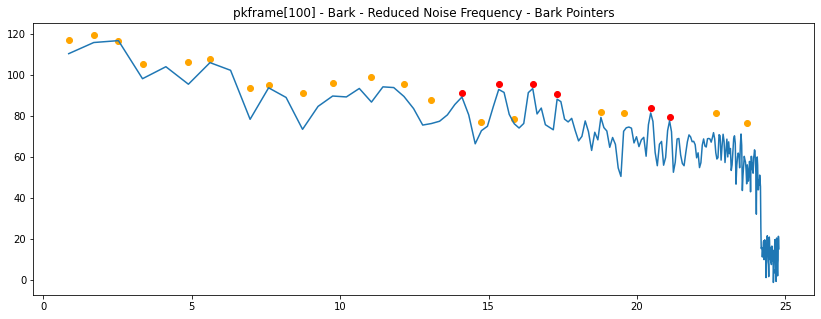

In [16]:
p_tmc = np.transpose(np.load("P_TMc.npy"))
p_nmc = np.transpose(np.load("P_NMc.npy"))

y5= []
for i in p_tmc[50]:
        
        if i == 0:
            i = None
        
        y5.append(i)

plt.figure(figsize = (14, 5))
plt.title('pkframe[50] - Bark - Reduced Tone Frequency - Bark Pointers')
plt.scatter(bark,y5,color="red")

y6= []
for i in p_nmc[50]:
        
        if i == 0:
            i = None
        
        y6.append(i)
        
plt.scatter(bark,y6,color="orange")
plt.plot(bark,pkframe[50])

plt.show()

y7= []
for i in p_tmc[100]:
        
        if i == 0:
            i = None
        
        y7.append(i)

plt.figure(figsize = (14, 5))
plt.title('pkframe[100] - Bark - Reduced Noise Frequency - Bark Pointers')
plt.scatter(bark,y7,color="red")

y8= []
for i in p_nmc[100]:
        
        if i == 0:
            i = None
        
        y8.append(i)

plt.scatter(bark,y8,color="orange")
plt.plot(bark,pkframe[100])
plt.show()

In [17]:
#1.4

t_g = np.zeros((nrframes,N//2))

def ttm_creation(maskj, p_tm, b):

    bj = b[maskj]
    start = bj-3
    end = bj+8

    ls_start = np.where(b<=start)

    if len(ls_start[0])>1:
        start = ls_start[0][len(ls_start[0])-1]
    else: start = 1 
    
    ls_end = np.where(b<=end)

    if len(ls_end[0])>1:
        end = ls_end[0][len(ls_end[0])-1]
    
    sf = np.zeros(end-start+1)
    for i in range(start,end):
        db = b[i] - bj
        if (db >= -3 and db<-1):
            sf[i-start] = 17*db - 0.4*p_tm + 11
        elif (db >= -1 and db < 0):
            sf[i-start] = (0.4*p_tm + 6)*db
        elif (db >= 0 and db < 1):
            sf[i-start] = -17*db
        elif (db >= 1 and db < 8.5):
            sf[i-start] = (0.15*p_tm - 17)*db - 0.15*p_tm
            
    #calculating tqs
    t_tm = np.zeros(N//2)
    for i in range(start,end):
        t_tm[i-start] = p_tm - 0.275*bj + sf[i-start] - 6.025
    return t_tm       
   
    
def tnm_creation(maskj, p_nm, b):
    bj = b[maskj]
    start = bj-3
    end = bj+8

    ls_start = np.where(b<=start)

    if len(ls_start[0])>1:
        start = ls_start[0][len(ls_start[0])-1]
    else: start = 1
    

    ls_end = np.where(b<=end)

    if len(ls_end[0])>1:
        end = ls_end[0][len(ls_end[0])-1]
    
    
    sf = np.zeros(end-start+1)
    for i in range(start,end):
        db = b[i] - bj
        if (db >= -3 and db<-1):
            sf[i-start] = 17*db - 0.4*p_nm + 11
        elif (db >= -1 and db < 0):
            sf[i-start] = (0.4*p_nm + 6)*db
        elif (db >= 0 and db < 1):
            sf[i-start] = -17*db
        elif (db >= 1 and db < 8.5):
            sf[i-start] = (0.15*p_nm - 17)*db - 0.15*p_nm
            
    t_nm = np.zeros(N//2)
    for i in range(start,end):
        t_nm[i-start] = p_nm - 0.275*bj + sf[i-start] - 2.025
    
    return t_nm


In [18]:

for i in range(nrframes):
    tm_indices = np.nonzero(p_tmc[i])[0]
    nm_indices = np.nonzero(p_nmc[i])[0]
    t_tm = np.zeros((len(tm_indices),N//2))
    
    t_nm = np.zeros((len(nm_indices),N//2))

    for j in range(len(tm_indices)):
        t_tm[j][:] = ttm_creation(tm_indices[j], p_tmc[i][tm_indices[j]], bark)
             
    for j in range(len(nm_indices)):
        t_nm[j][:] = tnm_creation(nm_indices[j], p_nmc[i][nm_indices[j]], bark)
        
    t_tm = t_tm.transpose()
    t_nm = t_nm.transpose()
    
    for j in range(N//2):
        result = 10*np.log10(10**(0.1*tq[j]) + np.sum(10**(0.1*t_tm[j])) + np.sum(10**(0.1*t_tm[j])))
        t_g[i][j] = (result)
        


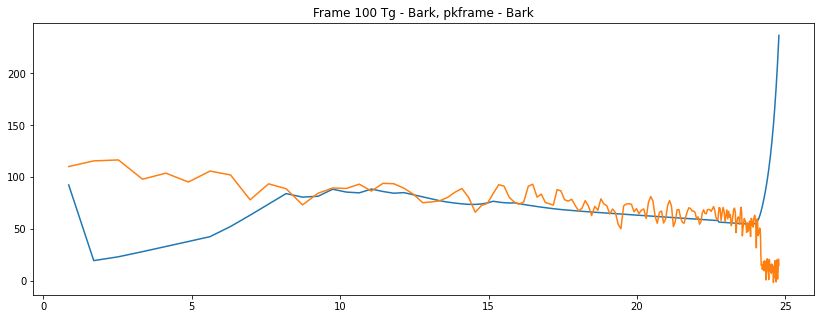

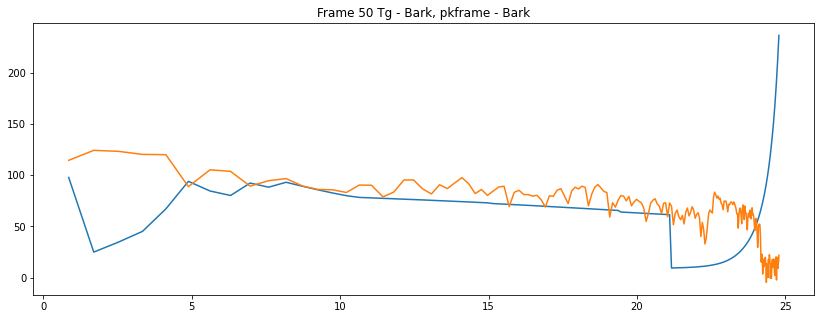

In [19]:
plt.figure(figsize = (14, 5))
plt.title('Frame 100 Tg - Bark, pkframe - Bark')
plt.plot(bark,t_g[100])
plt.plot(bark,pkframe[100])
plt.show()

plt.figure(figsize = (14, 5))
plt.title('Frame 50 Tg - Bark, pkframe - Bark')
plt.plot(bark,t_g[50])
plt.plot(bark,pkframe[50])
plt.show()


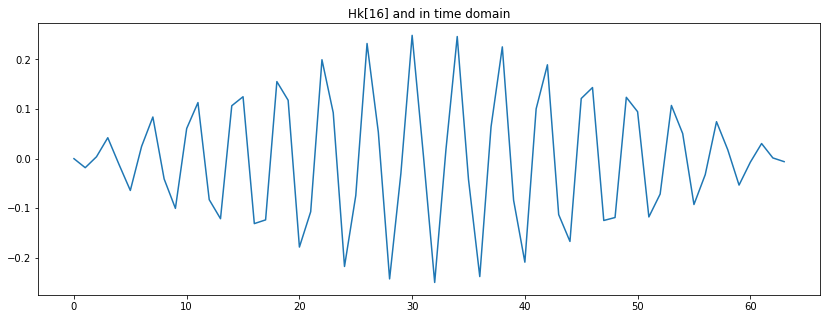

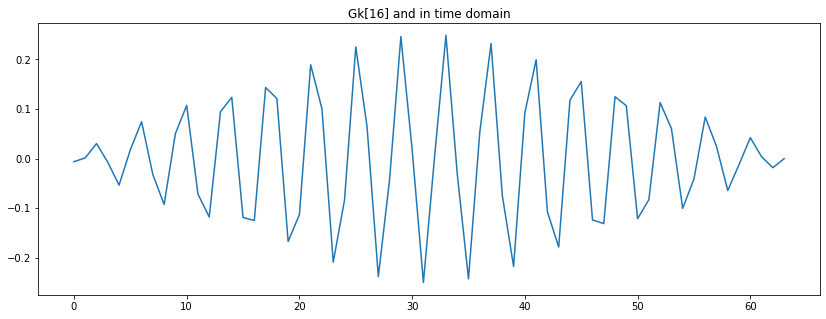

In [20]:
#2.0 
M = 32
L = 2*M
h_kn = np.zeros((M,L))
g_kn = np.zeros((M,L))
for k in range(M):
    for n in range(L):
        h_kn[k][n] = np.sin((n+1/2)*np.pi/(2*M)) * np.sqrt(2/M) * np.cos((2*n+M+1)*(2*k+1)*np.pi/(4*M))
for k in range(M):
    for n in range(L):
        g_kn[k][n] = h_kn[k][2*M-1-n]
        
plt.figure(figsize = (14, 5))
plt.title('Hk[16] and in time domain')
plt.plot(h_kn[16])

plt.figure(figsize = (14, 5))
plt.title('Gk[16] and in time domain')
plt.plot(g_kn[16])



In [21]:
#2.1

R = 2**16
output = np.zeros((nrframes,N+L-1//M + L-1))
overall_bits = 0
for fr in range(nrframes):
    #print("frame is" + str(fr))
    v_k = np.zeros((M,N+L-1))
    y_k = np.zeros((M,(N+L-1)//M + 1))
    yquant = np.zeros((M,(N+L-1)//M + 1))
    bits = 0
    for k in range(1,M+1):
        v_k[k-1] = np.convolve(h_kn[k-1],frames[fr])
        y_k[k-1] = scipy.signal.decimate(v_k[k-1],M) 
    
    
    #2.2 quantization
        tg_min = min(abs(t_g[fr][8*(k-1):8*(k+1)]))
        
        #print("k is"+str(k))
        b = np.log2(R/abs(tg_min)-1)
        b_k = int(b)
        
        maxyk = max(y_k[k-1])
        minyk = min(y_k[k-1])
        
        bits += b_k*len(y_k[k-1])
        
        delta = abs(maxyk-minyk)/2**b_k     
        
        for i in range(len(y_k[k-1])):
            result = int(y_k[k-1][i]-minyk/delta)
            if result == 2**b_k:
                result -= 1
            
            yquant[k-1][i] = delta*(result+1/2)+minyk      
            
        #2.3 synthesis
        
        w_k = scipy.signal.resample(yquant[k-1],len(yquant[k-1])*M)

        outg_k = 10*np.convolve(g_kn[k-1],w_k,'full')
        output[fr] = output[fr] + outg_k
        
    overall_bits += bits

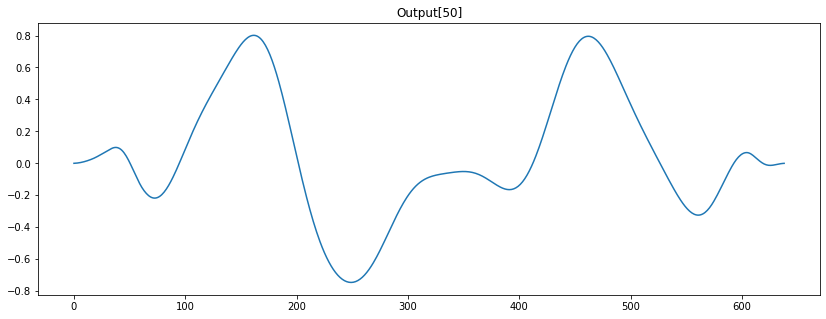

In [22]:
plt.figure(figsize = (14, 5))
plt.title('Output[50]')
plt.plot(output[50])

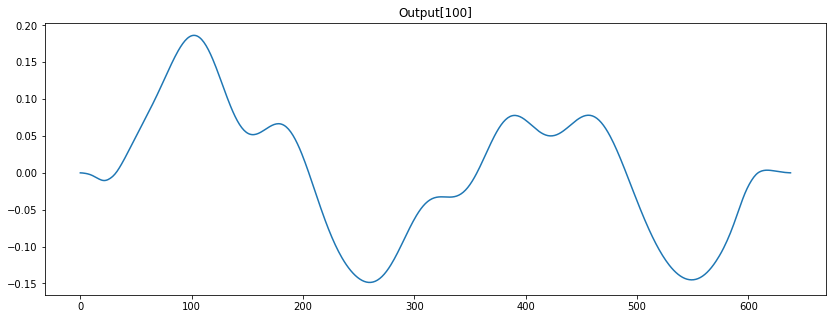

In [23]:
plt.figure(figsize = (14, 5))
plt.title('Output[100]')
plt.plot(output[100])

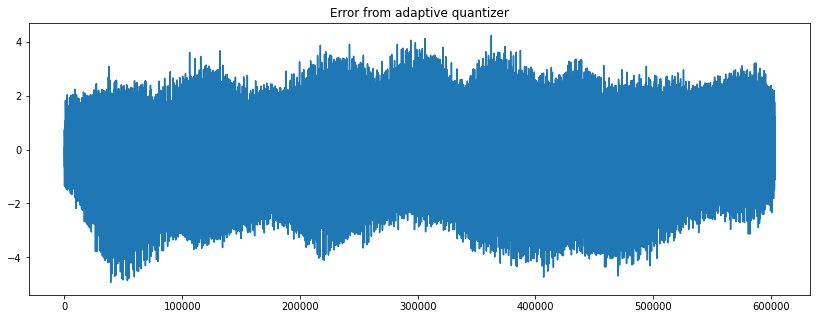

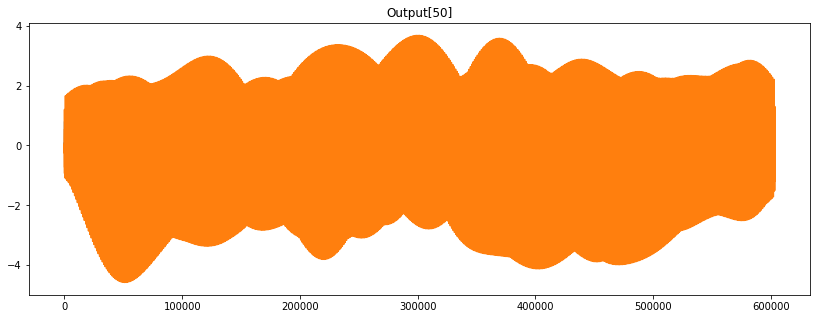

In [24]:
#reconstruction of music
L_rec = N+L-1//M + L-1
R_rec = N

output1 = np.zeros((nrframes,L_rec-4*M+1))
for fr in range(len(output)):
    output1[fr] = (output[fr][2*M:L_rec-2*M+1])

k = 0
rec_music = np.zeros(nrframes*(L_rec-4*M+1))

for j in range(L_rec-4*M+1):
    for i in range(nrframes):
        rec_music[k] += output1[i][j]
        k=k+1
rec_music = rec_music[:len(music)]

quantum_error = rec_music - music[:603136]
plt.figure(figsize = (14, 5))
plt.title('Error from adaptive quantizer')

plt.plot(quantum_error)

plt.figure(figsize = (14, 5))
plt.title('Output[50]')
plt.plot(output[50])
plt.plot(rec_music)

In [25]:
#8-bit quantizer
#same process

output_8bit = np.zeros((nrframes,N+L-1//M + L-1))
overall_bits = 0
for fr in range(nrframes):
    #print("frame is" + str(fr))
    v_k = np.zeros((M,N+L-1))
    y_k = np.zeros((M,(N+L-1)//M + 1))
    yquant = np.zeros((M,(N+L-1)//M + 1))
    bits = 0
    #output = np.zeros(N+L-1//M + L-1)
    for k in range(M):
        v_k[k] = np.convolve(h_kn[k],frames[fr])
        #downsampling
        y_k[k] = scipy.signal.decimate(v_k[k],M) 
    
    
    #2.2 quantization    
        b_k = int(8)#8bits quantizer PONNY
        
        maxyk = 1
        minyk = -1
        
        bits += b_k*len(y_k[k])
        
        delta = abs(maxyk-minyk)/2**b_k       
        
        for i in range(len(y_k[k])):
            result = int(y_k[k][i]-minyk/delta)
            if result == 2**b_k:
                result -= 1
            
            yquant[k][i] = delta*(result+1/2)+minyk            
            
        #2.3 synthesis
        
        w_k = scipy.signal.resample(yquant[k],len(yquant[k])*M)
        
        outg_k = 10*np.convolve(g_kn[k],w_k,'full')
        output_8bit[fr] = output_8bit[fr] + outg_k
    overall_bits += bits
    


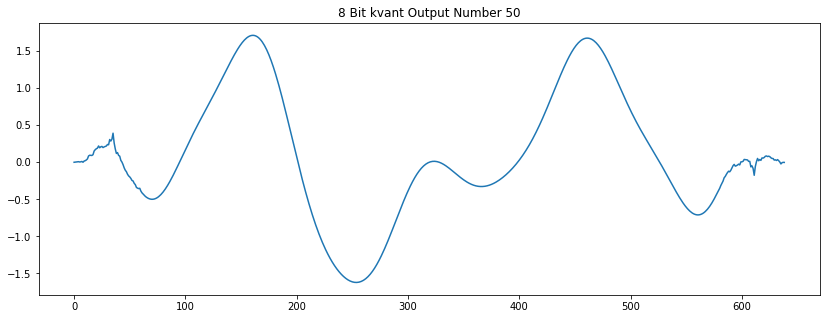

In [26]:
plt.figure(figsize = (14, 5))
plt.title('8 Bit kvant Output Number 50')
plt.plot(output_8bit[50])

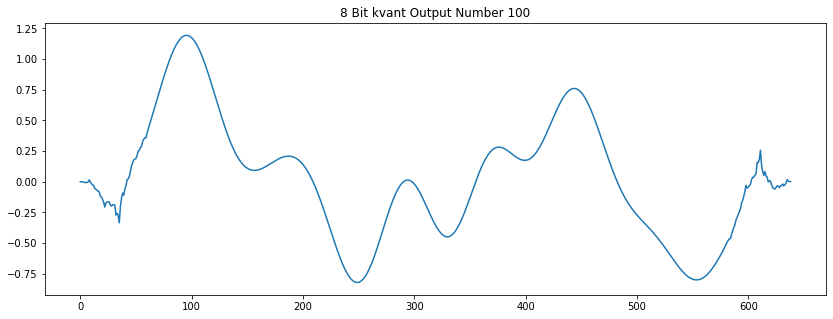

In [27]:
plt.figure(figsize = (14, 5))
plt.title('8 Bit kvant Output Number 100')
plt.plot(output_8bit[100])

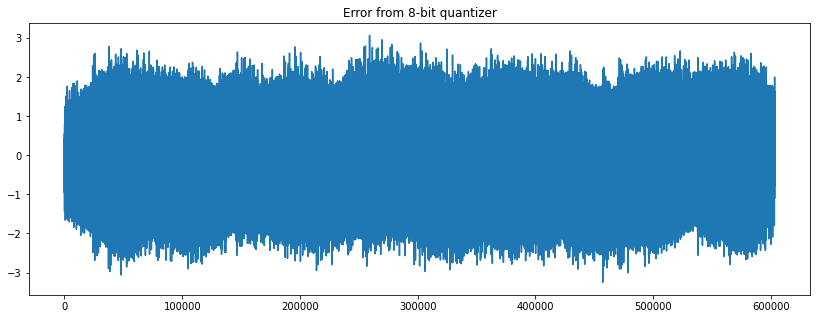

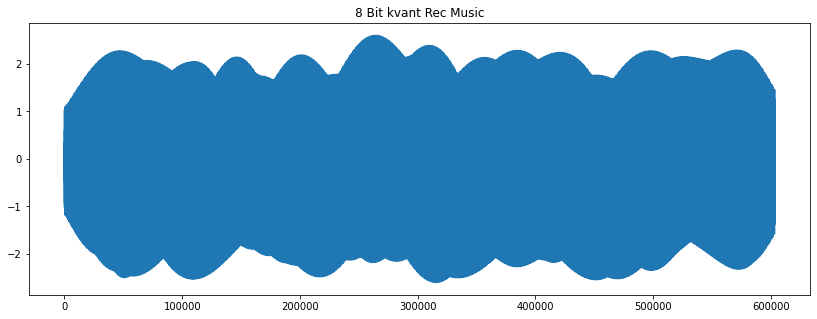

In [28]:
output2 = np.zeros((nrframes,L_rec-4*M+1))
for fr in range(len(output_8bit)):
    output2[fr] = (output_8bit[fr][2*M:L_rec-2*M+1])

k = 0
rec_music_8bit = np.zeros(nrframes*(L_rec-4*M+1))

for j in range(L_rec-4*M+1):
    for i in range(nrframes):
        rec_music_8bit[k] += output2[i][j]
        k=k+1
rec_music_8bit = rec_music_8bit[:len(music)]

quantum8_error = rec_music_8bit - music[:603136]
plt.figure(figsize = (14, 5))
plt.title('Error from 8-bit quantizer')
plt.plot(quantum8_error)

plt.figure(figsize = (14, 5))
plt.title('8 Bit kvant Rec Music')
plt.plot(rec_music_8bit)

In [29]:
sf.write('new_music.wav', rec_music, 44100)
sf.write('8_bit_music.wav', rec_music_8bit, 44100)